In [1]:
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import os, sys
import copy
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import sem

from palettable.colorbrewer.sequential import GnBu_6_r, GnBu_8_r
from palettable.cartocolors.qualitative import Safe_2, Safe_3

sns.set_context("notebook", font_scale=3.1, rc={"lines.linewidth": 3.5, "figure.figsize": (8,6), "font.family": "Times"})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["legend.columnspacing"]  = 1.2
plt.rcParams["legend.labelspacing"]  = 0.32
plt.rcParams["legend.borderaxespad"]  = 0.32
plt.rcParams["legend.borderpad"]  = 0.32
plt.rcParams["legend.fontsize"] = 32
plt.rcParams["legend.handlelength"] = 1.6
plt.rcParams["legend.handletextpad"] = 0.4
plt.rcParams['lines.markersize'] = 12
plt.rcParams['lines.markerfacecolor'] = 'white'
plt.rcParams['lines.markeredgewidth'] = 2

from cycler import cycler
marker_list = ['o','X','P','s','v','D','H','p','^','*']

In [ ]:
def load_hartmann_file(nAgent, base, C1, noise_std, vary):
    file = './results/result_hartmann_nAgent={}_OWA_base={}_C1={}_std={}_vary_{}'.format(nAgent, base, C1, noise_std, vary)
    return torch.load(file)

def load_hartmann_files(nAgent, C1, noise_std, vary, bases=[1, 0.8, 0.6, 0.4, 0.2]):
    results = dict()

    for base in bases:
        try:
            results[base] = load_hartmann_file(nAgent, base, C1, noise_std, vary):
            d = results[base]['obsX'].shape[-1]
            if d == 6:
                fmax = 3.32237
            else:
                TypeError('Invalid Method')
            results[base]['obsR'] = fmax - results[base]['obsF']
        except FileNotFoundError:
            continue
    print("Found bases", results.keys())
    return results



results3 = load_hartmann_files(3, 0.08, 0.1, False)
vresults3 = load_hartmann_files(3, 0.08, 0.1, True)


In [3]:
def load_hyp_files(exp, C1, vary, bases=[1, 0.8, 0.6, 0.4, 0.2]):
    results = dict()

    for base in bases:
        try:
            file = './results/result_{}_base={}_c1={}_vary={}.pt'.format(exp, base, C1, vary)
            
            results[base] = torch.load(file)
            fmax = 1
            results[base]['obsF'] = results[base]['obsY']
            results[base]['obsR'] = fmax - results[base]['obsF']
            print(results[base]['obsR'].min(2)[0].max(1)[0])
        except FileNotFoundError:
            continue
    print("Found bases", results.keys())
    return results


def load_traffic_files(C1, vary, bases=[1, 0.8, 0.6, 0.4, 0.2]):
    results = dict()

    for base in bases:
        try:
            file = './results/result_traffic_ns={}_nAgent={}_base={}_C1={}_vary={}'.format(ns, nAgent, base, C1, vary)
            results[base] = torch.load(file)
            fmax = np.log1p(96)
            results[base]['obsY'] = results[base]['obsY'] 
            results[base]['obsF'] = results[base]['obsY']
            results[base]['obsR'] = fmax - results[base]['obsF']
           
        except FileNotFoundError:
            continue
    print("Found bases", results.keys())
    return results


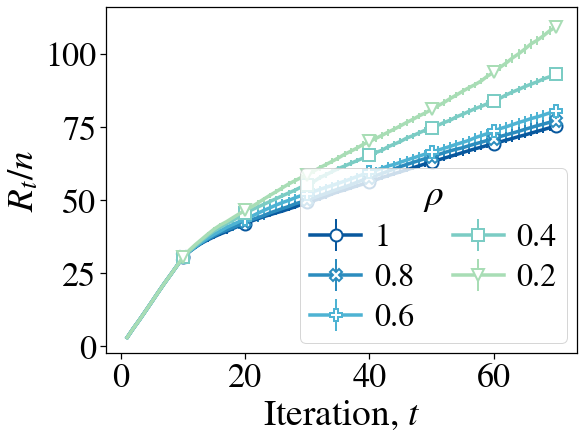

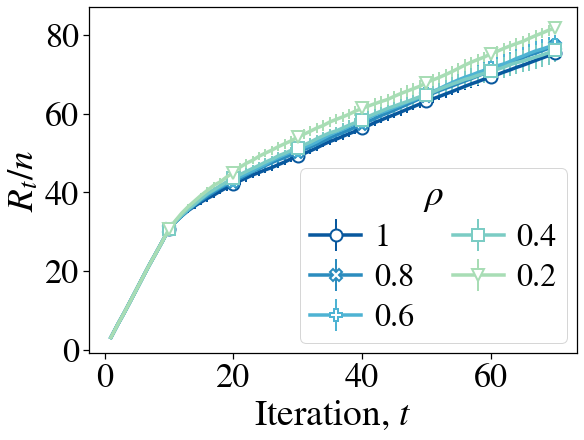

In [5]:

def plot_CR(result_dict, exp_name, bases, ucb_result=None, worst=False):
    color_cycler = cycler(color=GnBu_8_r.mpl_colors[:6])
    marker_cycler = cycler(marker= marker_list[:6])
    combined_cycler = (color_cycler + marker_cycler)
    plt.rc('axes', prop_cycle=combined_cycler)
    result_dict = result_dict.copy()
    if ucb_result is not None:
        result_dict["UCB"] = ucb_result
    for key, result in result_dict.items():
        if key not in bases:
            continue
        obsR = result['obsR']
        cumR = obsR.cumsum(-1)
        if not worst:
            avg_cumR_across_parties = cumR.mean(1)
            plt.ylabel(r"$R_t/n$")
        else:
            avg_cumR_across_parties = cumR.max(1)[0]
            plt.ylabel("Worst " + r"$R_t^i$")
        n_iterations = avg_cumR_across_parties.shape[-1]
        iterations = torch.arange(n_iterations) + 1
        mean_cumR_across_runs = avg_cumR_across_parties.mean(0)
        sem_cumR_across_runs = sem(avg_cumR_across_parties, axis=0)

        plt.errorbar(iterations,  mean_cumR_across_runs, yerr=sem_cumR_across_runs, label=key, elinewidth=2., markevery=np.arange(10-1,len(iterations),10))
        
    
    # plt.title("Cumulative Regret of {}".format(exp_name))
    plt.xlabel("Iteration, " + r"$t$")
    plt.legend(title=r"$\rho$", ncol=2)

    if not worst:
        savename="./pdf/{}-avg_cr_vs_t.pdf".format(exp_name)
    else:
        savename="./pdf/{}-worst_cr_vs_t.pdf".format(exp_name)
    plt.savefig(savename, format='pdf')
    plt.show()

plot_CR(results3, "Hartmann-6d, n=3",[1, 0.8, 0.6, 0.4, 0.2])
plot_CR(vresults3, "Hartmann-6d (Vary), n=3",[1, 0.8, 0.6, 0.4, 0.2])


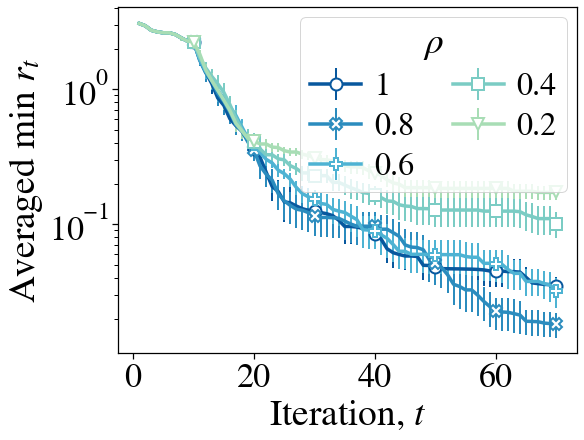

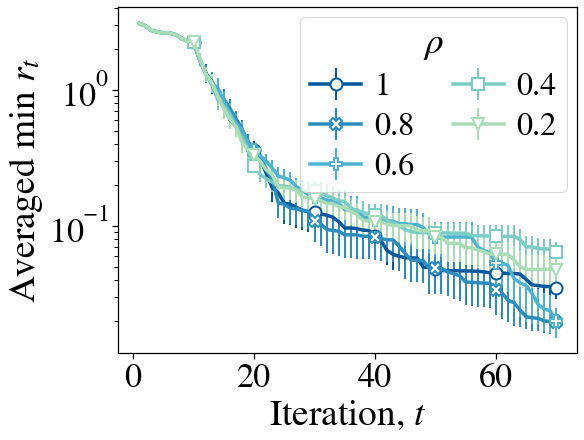

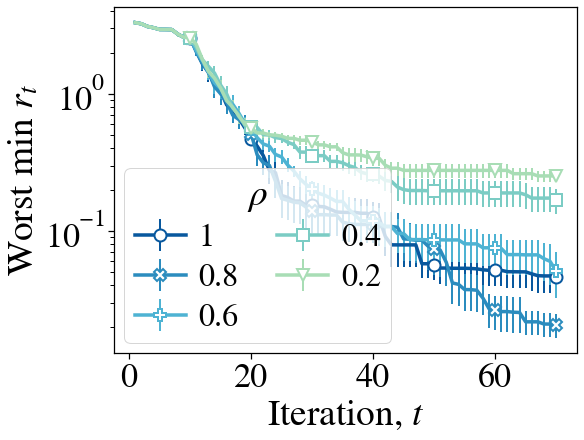

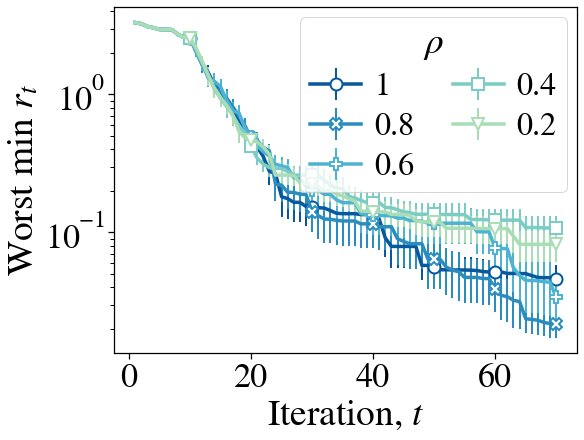

In [6]:
def plot_SR(result_dict, exp_name, bases, ucb_result=None, worst=False):
    color_cycler = cycler(color=GnBu_8_r.mpl_colors[:6])
    marker_cycler = cycler(marker= marker_list[:6])
    combined_cycler = (color_cycler + marker_cycler)
    plt.rc('axes', prop_cycle=combined_cycler)
    result_dict = result_dict.copy()
    if ucb_result is not None:
        result_dict["UCB"] = ucb_result
    for key, result in result_dict.items():
        if key not in bases:
            continue
        obsR = result['obsR']
        cumR = obsR.cummin(-1)[0]
        if not worst:
            avg_cumR_across_parties = cumR.mean(1)
            plt.ylabel("Averaged min " + r"$r_t$")
        else:
            avg_cumR_across_parties = cumR.max(1)[0]
            plt.ylabel("Worst min " + r"$r_t$")
        n_iterations = avg_cumR_across_parties.shape[-1]
        iterations = torch.arange(n_iterations) + 1
        mean_cumR_across_runs = avg_cumR_across_parties.mean(0)
        sem_cumR_across_runs = sem(avg_cumR_across_parties, axis=0)

        plt.errorbar(iterations,  mean_cumR_across_runs, yerr=sem_cumR_across_runs, label=key, elinewidth=2., markevery=np.arange(10-1,len(iterations),10))
        

    plt.xlabel("Iteration, " + r"$t$")
    plt.yscale("log")
    plt.legend(title=r"$\rho$", ncol=2)

    if not worst:
        savename="./pdf/{}-avg_sr_vs_t.pdf".format(exp_name)
    else:
        savename="./pdf/{}-worst_sr_vs_t.pdf".format(exp_name)
    plt.savefig(savename, format='pdf')
    plt.show()

plot_SR(results3, "Hartmann-6d, n=3",[1, 0.8, 0.6, 0.4, 0.2])
plot_SR(vresults3, "Hartmann-6d (Vary), n=3",[1, 0.8, 0.6, 0.4, 0.2])
plot_SR(results3, "Hartmann-6d, n=3",[1, 0.8, 0.6, 0.4, 0.2], worst=True)
plot_SR(vresults3, "Hartmann-6d (Vary), n=3",[1, 0.8, 0.6, 0.4, 0.2], worst=True)

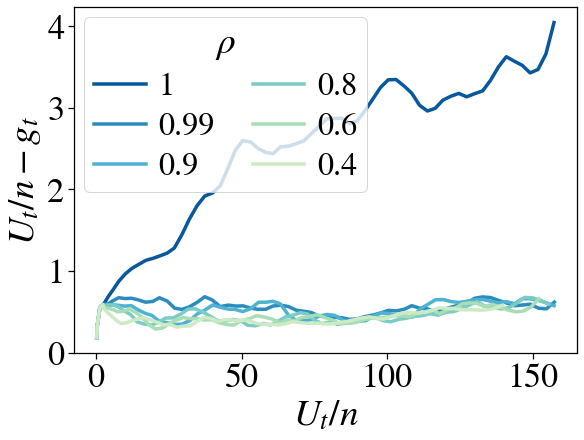

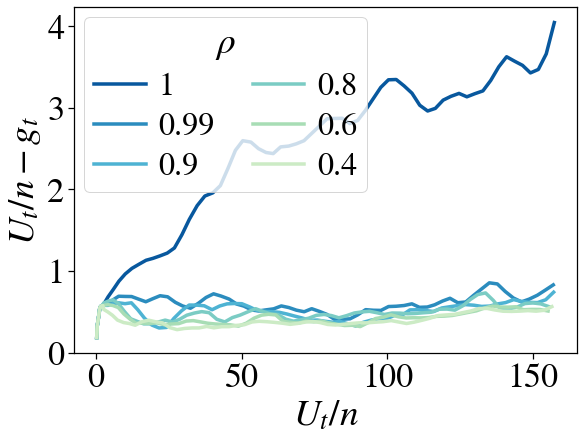

In [8]:
def plot_CU_fairness(result_dict, exp_name, bases, regret_rho):
    color_cycler = cycler(color=GnBu_8_r.mpl_colors[:6])
    plt.rc('axes', prop_cycle=color_cycler)
    count = 0
    for key, result in result_dict.items():
        if key not in bases:
            continue
        count += 1
        obsF = result['obsF']
        cumF = obsF.cumsum(-1)
        avg_cumF_across_parties = cumF.mean(1)

        mean_cumF_across_runs = avg_cumF_across_parties.mean(0)

        def cal_owa_utility():
            n = obsF.shape[1]
            weights = torch.pow(regret_rho, torch.arange(n)) 
            weights =  weights/torch.sum(weights)

            cumF =  result['obsF'].cumsum(-1)

            second = torch.sort(cumF , axis=1)[0]
            second = torch.tensordot(second, weights, dims=([1],[0]))

            return second.mean(0), sem(second, axis=0)

        mean_owa_u_t, sem_owa_u_t = cal_owa_utility()

        # Smoothen
        new_y = savgol_filter(mean_cumF_across_runs - mean_owa_u_t , 7, 3)

        plt.plot(mean_cumF_across_runs, new_y, label=key)

    plt.xlabel(r"$U_t/n$")
    plt.ylabel(r"$U_t/n - g_t$")
    plt.legend(title=r"$\rho$", ncol=count//3)

    savename="./pdf/{}-fairness.pdf".format(exp_name)
    plt.savefig(savename, format='pdf')
    plt.show()



plot_CU_fairness(results3, "Hartmann-6d, n=3", [1, .99, 0.9, 0.8, 0.6, 0.4], 0.2)
plot_CU_fairness(vresults3, "Hartmann-6d (Vary), n=3",[1, .99, 0.9, 0.8, 0.6, 0.4], 0.2)

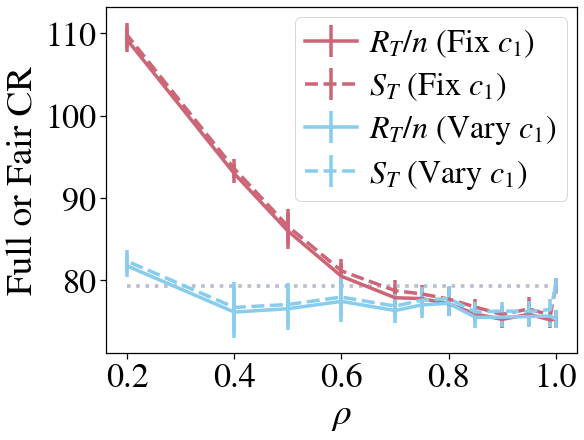

In [4]:

from math import ceil

def plot_final_regrets_part(result_dict, regret_rho, bases=None, color=None,  marker=None, append="", ax=None):
    R_T_mean, R_T_sem = [], []
    S_T_mean, S_T_sem = [], []
    keys = []

    for key, result in result_dict.items():
        if bases is not None and key not in bases:
            continue
        keys.append(key)

        avg_R_T = result['obsR'].sum(-1).mean(1)
        R_T_mean.append(avg_R_T.mean(0))
        R_T_sem.append(sem(avg_R_T, axis=0))

        def cal_owa_regret():
            n = result['obsF'].shape[1]
            weights = torch.pow(regret_rho, torch.arange(n)) 
            weights =  weights/torch.sum(weights)

            cumF =  result['obsF'].cumsum(-1)
            lambdas = cumF - result['obsF']

            fmax = (result['obsF'] + result['obsR']).mean()

            first = torch.sort(lambdas + fmax, axis=1)[0]
            first = torch.tensordot(first, weights, dims=([1],[0])) 

            second = torch.sort(cumF , axis=1)[0]
            second = torch.tensordot(second, weights, dims=([1],[0]))

            ret = (first - second).cumsum(-1)

            return ret.mean(0), sem(ret, axis=0)
        
        mean_s_t, sem_s_t = cal_owa_regret()
        S_T_mean.append(mean_s_t[-1])
        S_T_sem.append(sem_s_t[-1])

        if key == 1:
            S_T1 = mean_s_t[-1]
            R_T1 = avg_R_T.mean(0)
        
        is_not_st = torch.allclose(result['obsF'], result['obsY'])

    # s_label = r"$S_T'$" if is_not_st else r"$S_T$"
    s_label = r"$S_T$"

    ax.errorbar(keys, R_T_mean, yerr=R_T_sem, label=r"$R_T/n$" + append, color=color, marker=marker)
    ax.errorbar(keys, S_T_mean, yerr=S_T_sem, label=s_label + append, linestyle='dashed', color=color, marker=marker)
    ax.hlines(xmin=min(keys), xmax=1, y=S_T1, linestyle="dotted", alpha=0.5, color=color)

    return ax, R_T1


def plot_final_regrets_both(result_dict, v_result_dict, exp_name, regret_rho, bases=None, numkey=5):

    colors = Safe_2.mpl_colors

    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()

    _, R_T1 = plot_final_regrets_part(result_dict, regret_rho, bases=bases, color=colors[1], append=" (Fix {})".format(r"$c_1$"), ax=ax1)
    plot_final_regrets_part(v_result_dict, regret_rho, bases=bases, color=colors[0], append=" (Vary {})".format(r"$c_1$"),  ax=ax1)

    ax1.set_xlabel(r"$\rho$", axes=ax1)
    ax1.set_ylabel("Full or Fair CR")
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend() 
    savename="./pdf/{}-rt_vs_st.pdf".format(exp_name)
    plt.xticks(np.linspace(min(result_dict.keys()), max(result_dict.keys()), num=numkey))
    plt.savefig(savename, format='pdf')
    plt.show()

plot_final_regrets_both(results3, vresults3, "Hartmann-6d, n=3", 0.2)


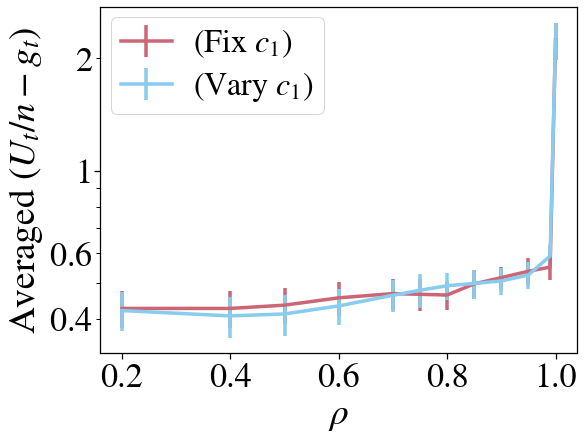

In [14]:
from mpl_axes_aligner import align
from math import ceil

from matplotlib.ticker import LogFormatterSciNotation

plt.rcParams['axes.formatter.min_exponent'] = 2

def plot_avg_fairness_part(result_dict, regret_rho, bases=None, color=None, append="", ax=None):
    marker_cycler = cycler(marker=marker_list)
    plt.rc('axes', prop_cycle=marker_cycler)
    
    diff_vals, sem_vals = [], []
    keys = []

    for key, result in result_dict.items():
        if bases is not None and key not in bases:
            continue
        keys.append(key)

        obsF = result['obsF']
        cumF = obsF.cumsum(-1)
        avg_cumF_across_parties = cumF.mean(1)
        dim = 1

        mean_cumF_across_runs = avg_cumF_across_parties.mean(dim)

        def cal_owa_utility():
            n = obsF.shape[1]
            weights = torch.pow(regret_rho, torch.arange(n)) 
            weights =  weights/torch.sum(weights)

            cumF =  result['obsF'].cumsum(-1)

            second = torch.sort(cumF , axis=1)[0]
            second = torch.tensordot(second, weights, dims=([1],[0]))

            return second.mean(dim)

        mean_owa_u_t = cal_owa_utility()

        diff = mean_cumF_across_runs - mean_owa_u_t

        sem_val = sem(diff, axis=0)

        diff_vals.append(diff.mean())
        sem_vals.append(sem_val.mean())

    ax.errorbar(keys, diff_vals, yerr=sem_vals, label="" + append, color=color)

def plot_avg_fairness_both(result_dict, v_result_dict, exp_name, regret_rho, bases=None, numkey=5):
    colors = Safe_2.mpl_colors

    fig, ax1 = plt.subplots()

    plot_avg_fairness_part(result_dict, regret_rho, bases=bases, color=colors[1], append=" (Fix {})".format(r"$c_1$"), ax=ax1)
    plot_avg_fairness_part(v_result_dict, regret_rho, bases=bases, color=colors[0], append=" (Vary {})".format(r"$c_1$"), ax=ax1)

    ax1.set_xlabel(r"$\rho$", axes=ax1)
    ax1.set_ylabel("Averaged " + r"$(U_t/n - g_t)$")
    ax1.set_yscale("log")

    ax1.legend()
    savename="./pdf/{}-fairness_rho.pdf".format(exp_name)
    plt.xticks(np.linspace(min(result_dict.keys()), max(result_dict.keys()), num=numkey))
    plt.savefig(savename, format='pdf')
    plt.show()

plot_avg_fairness_both(results3, vresults3, "Hartmann-6d, n=3", 0.2)